Import libraries required and read in the data.
Look at the structure of the dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

df = pd.read_csv('./survey_results_public.csv')
pd.set_option('display.max_columns', 500)
df.head()

,Respondent,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,CurrencySymbol,DatabaseDesireNextYear,DatabaseWorkedWith,DevType,EdLevel,Employment,Ethnicity,Gender,JobFactors,JobSat,JobSeek,LanguageDesireNextYear,LanguageWorkedWith,MiscTechDesireNextYear,MiscTechWorkedWith,NEWCollabToolsDesireNextYear,NEWCollabToolsWorkedWith,NEWDevOps,NEWDevOpsImpt,NEWEdImpt,NEWJobHunt,NEWJobHuntResearch,NEWLearn,NEWOffTopic,NEWOnboardGood,NEWOtherComms,NEWOvertime,NEWPurchaseResearch,NEWPurpleLink,NEWSOSites,NEWStuck,OpSys,OrgSize,PlatformDesireNextYear,PlatformWorkedWith,PurchaseWhat,Sexuality,SOAccount,SOComm,SOPartFreq,SOVisitFreq,SurveyEase,SurveyLength,Trans,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro
0,1,I am a developer by profession,Yes,NaN,13,Monthly,NaN,NaN,Germany,European Euro,EUR,Microsoft SQL Server,Elasticsearch;Microsoft SQL Server;Oracle,"Developer, desktop or enterprise applications;...","Master’s degree (M.A., M.S., M.Eng., MBA, etc.)","Independent contractor, freelancer, or self-em...",White or of European descent,Man,"Languages, frameworks, and other technologies ...",Slightly satisfied,I am not interested in new job opportunities,C#;HTML/CSS;JavaScript,C#;HTML/CSS;JavaScript,.NET Core;Xamarin,.NET;.NET Core,Microsoft Teams;Microsoft Azure;Trello,Confluence;Jira;Slack;Microsoft Azure;Trello,No,Somewhat important,Fairly important,NaN,NaN,Once a year,Not sure,NaN,No,Often: 1-2 days per week or more,Start a free trial;Ask developers I know/work ...,Amused,Stack Overflow (public Q&A for anyone who codes),Visit Stack Overflow;Go for a walk or other ph...,Windows,2 to 9 employees,Android;iOS;Kubernetes;Microsoft Azure;Windows,Windows,NaN,Straight / Heterosexual,No,"No, not at all",NaN,Multiple times per day,Neither easy nor difficult,Appropriate in length,No,"Computer science, computer engineering, or sof...",ASP.NET Core,ASP.NET;ASP.NET Core,Just as welcome now as I felt last year,50.0,36,27
1,2,I am a developer by profession,No,NaN,19,NaN,NaN,NaN,United Kingdom,Pound sterling,GBP,NaN,NaN,"Developer, full-stack;Developer, mobile","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Employed full-time,NaN,NaN,NaN,Very dissatisfied,I am not interested in new job opportunities,Python;Swift,JavaScript;Swift,React Native;TensorFlow;Unity 3D,React Native,Github;Slack,Confluence;Jira;Github;Gitlab;Slack,NaN,NaN,Fairly important,NaN,NaN,Once a year,Not sure,NaN,No,NaN,NaN,Amused,Stack Overflow (public Q&A for anyone who code...,Visit Stack Overflow;Go for a walk or other ph...,MacOS,"1,000 to 4,999 employees",iOS;Kubernetes;Linux;MacOS,iOS,I have little or no influence,NaN,Yes,"Yes, definitely",Less than once per month or monthly,Multiple times per day,NaN,NaN,NaN,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat more welcome now than last year,NaN,7,4
2,3,I code primarily as a hobby,Yes,NaN,15,NaN,NaN,NaN,Russian Federation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Objective-C;Python;Swift,Objective-C;Python;Swift,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Once a decade,NaN,NaN,No,NaN,NaN,NaN,Stack Overflow (public Q&A for anyone who codes),NaN,Linux-based,NaN,NaN,NaN,NaN,NaN,Yes,"Yes, somewhat",A few times per month or weekly,Daily or almost daily,Neither easy nor difficult,Appropriate in length,NaN,NaN,NaN,NaN,Somewhat more welcome now than last year,NaN,4,NaN
3,4,I am a developer by profession,Yes,25.0,18,NaN,NaN,NaN,Albania,Albanian lek,ALL,NaN,NaN,NaN,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",NaN,White or of European descent,Man,Flex time or a flexible schedule;Office enviro...,Slightly dissatisfied,"I’m not actively looking, but I am open to new...",NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,Not at all important/not necessary,Curious about other opportunities;Wanting to w...,NaN,Once a year,Not sure,Yes,Yes,Occasionally: 1-2 days per quarter but less th...,NaN,NaN,Stack Overflow (public Q&A for anyone who code...,NaN,Lin

In [2]:
df.shape

(64461, 61)

In [73]:
# This is actually the number of respondents I have for each set
test=df.dropna(subset=['NEWJobHunt'],axis=0)
print(test.shape)

test2=df.dropna(subset=['JobFactors'],axis=0)
print(test2.shape)

(42286, 61)
(49349, 61)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64461 entries, 0 to 64460
Data columns (total 61 columns):
Respondent                      64461 non-null int64
MainBranch                      64162 non-null object
Hobbyist                        64416 non-null object
Age                             45446 non-null float64
Age1stCode                      57900 non-null object
CompFreq                        40069 non-null object
CompTotal                       34826 non-null float64
ConvertedComp                   34756 non-null float64
Country                         64072 non-null object
CurrencyDesc                    45472 non-null object
CurrencySymbol                  45472 non-null object
DatabaseDesireNextYear          44070 non-null object
DatabaseWorkedWith              49537 non-null object
DevType                         49370 non-null object
EdLevel                         57431 non-null object
Employment                      63854 non-null object
Ethnicity                

See how many females took the survey since I'd like to make comparison of responses between genders.

*In my analysis going forward, I will remove rows with null values in the column I'm analyzing for each particular question/section. This I believe is the only reasonable way to account for missing values, since we don't know why a respondent did not choose an answer. I don't want to fill in a guess for the missing values (which is actually only possible for the next few plots of gender, ethnicity, and job-seeking status, not for further quesions that I analyze, which have multiple responses).*

Man                                                        0.910121
Woman                                                      0.076033
Non-binary, genderqueer, or gender non-conforming          0.007615
Man;Non-binary, genderqueer, or gender non-conforming      0.002393
Woman;Non-binary, genderqueer, or gender non-conforming    0.001820
Name: Gender, dtype: float64

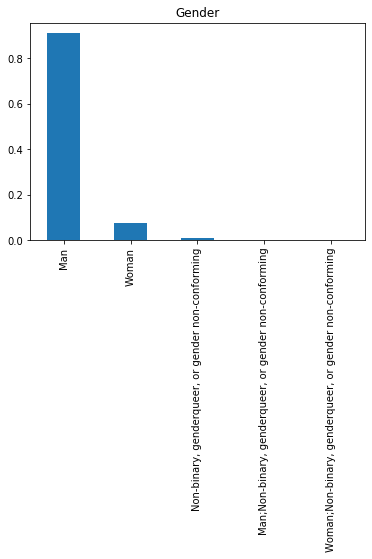

In [47]:
count_vals = df.Gender.value_counts() #Provide a pandas series of the counts for each gender

(count_vals[:5]/df.dropna(subset=['Gender'],axis=0).shape[0]).plot(kind="bar");
plt.title("Gender");

count_vals[:5]/df.dropna(subset=['Gender'],axis=0).shape[0]

There's only about 8% female respondents, but it's still almost 4,000 individual women, so I'll use it. For the statistical analysis at the end, I will verify assumptions for validity are verified.

I'd like to find out why/how developers seek new jobs. In particular, how does this change for minorities?
Start exploring questions related to seeking work.

In [48]:
df.NEWJobHunt.value_counts()

Curious about other opportunities;Better compensation;Wanting to work with new technologies;Growth or leadership opportunities                                                                                                                                                      1127
Curious about other opportunities;Better compensation;Better work/life balance;Wanting to work with new technologies;Growth or leadership opportunities                                                                                                                             1121
Better compensation                                                                                                                                                                                                                                                                  803
Curious about other opportunities;Better compensation;Wanting to work with new technologies                                                                  

This must be cleaned. Make a function for future columns that will need to be similarly cleaned.

In [58]:
from collections import defaultdict

possible_vals_NEWJobHunt = ["Just because", "Having a bad day (or week or month) at work",
                 "Wanting to share accomplishments with a wider network",
                 "Curious about other opportunities", "Better compensation",
                 "Trouble with my teammates", "Trouble with my direct manager",
                 "Trouble with leadership at my company", "Better work/life balance",
                 "Wanting to work with new technologies", "Growth or leadership opportunities",
                 "Looking to relocate", "Other"]

def total_count(df, col1, col2, look_for): # Copied from helper functions in Lesson 1
    '''
    INPUT:
    df - the pandas dataframe you want to search
    col1 - the column name you want to look through
    col2 - the column you want to count values from
    look_for - a list of strings you want to search for in each row of df[col]

    OUTPUT:
    new_df - a dataframe of each look_for with the count of how often it shows up
    '''
    new_df = defaultdict(int)
    #loop through list of values
    for val in look_for:
        #loop through rows
        for idx in range(df.shape[0]):
            #if the value is in the row add 1
            if val in df[col1][idx]:
                new_df[val] += int(df[col2][idx])
    new_df = pd.DataFrame(pd.Series(new_df)).reset_index()
    new_df.columns = [col1, col2]
    new_df.sort_values('count', ascending=False, inplace=True)
    return new_df

def clean_and_plot(df, possible_vals, col_to_clean='NEWJobHunt', title='Job-Seeking Drivers', plot=True): # Copied from Lesson 1, adapted for NEWJobHunt variable
    '''
    *Make sure df is clean of NaNs in col_to_clean*
    INPUT 
        df - a dataframe holding the col_to_clean column
        col_to_clean - column in df for which we are finding counts
        possible_vals - possible values to look for in col_to_clean
        title - string the title of your plot
        axis - axis object
        plot - bool providing whether or not you want a plot back
        
    OUTPUT
        study_df - a dataframe with the count of how many individuals
        (Optionally) displays a plot of pretty things related to the col_to_clean column.
        (Optionally) ax - axis handle to the plot
    '''
    study = df[col_to_clean].value_counts().reset_index()
    study.rename(columns={'index': 'value', col_to_clean: 'count'}, inplace=True)
    study_df = total_count(study, 'value', 'count', possible_vals)

    study_df.set_index('value', inplace=True)
    if plot:
#         ax=(study_df/study_df.sum()).plot(kind='bar', legend=None);
        ax=(study_df/df.shape[0]*100).plot(kind='bar', legend=None);
        plt.title(title);
#         plt.show()
#     out_df = study_df/study_df.sum()
    out_df = study_df/df.shape[0]
    # I had to change the above from study_df.sum() to df.shape[0] because we're interested in the proportion
    # of individuals choosing a certain answer, regardless of what additionally they chose
    
    try:
        out_df = out_df[0] # in case it comes out as a tuple
    except:
        out_df = out_df
    
    if plot:
        return out_df,ax
    else:
        return out_df

#### Question 1: What factors drive the respondents to seek new jobs?

,count
value,
Better compensation,0.699546
Wanting to work with new technologies,0.585229
Curious about other opportunities,0.571442
Growth or leadership opportunities,0.529442
Better work/life balance,0.482618
Trouble with leadership at my company,0.267961
Looking to relocate,0.262877
Having a bad day (or week or month) at work,0.202880
Trouble with my direct manager,0.170080


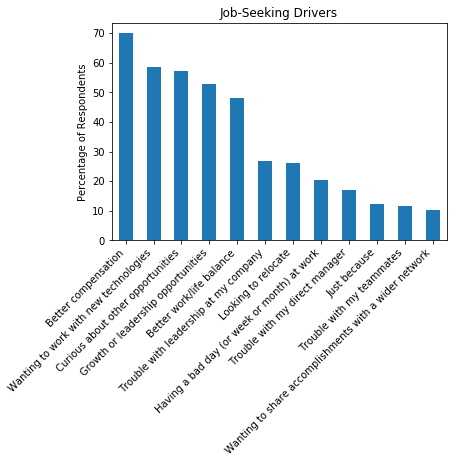

In [59]:
# First, drop any null values in the column we're interested in, since we can't guess the missing values, and don't know
# why the question was skipped by the respondent
df_clean_NEWJobHunt = df.dropna(subset=['NEWJobHunt'],axis=0)
# drivers_df,ax = clean_and_plot(df, possible_vals_NEWJobHunt)
drivers_df,ax = clean_and_plot(df_clean_NEWJobHunt, possible_vals_NEWJobHunt)
ax.set_xticklabels(list(drivers_df.index),rotation=45, ha='right');
ax.set_xlabel('')
ax.set_ylabel('Percentage of Respondents')
drivers_df

#### Question 2: What factors are most important when choosing a new job?

The next response I want to look at is the most important factors when choosing between 2 job positions.
The respondents were asked to choose 3 factors, assuming the 2 jobs had the same compensation, benefits, and location.

In [8]:
df.JobFactors.value_counts()

Flex time or a flexible schedule;Languages, frameworks, and other technologies I’d be working with;Remote work options                                2777
Languages, frameworks, and other technologies I’d be working with;Office environment or company culture;Opportunities for professional development    2570
Flex time or a flexible schedule;Languages, frameworks, and other technologies I’d be working with;Office environment or company culture              2508
Flex time or a flexible schedule;Languages, frameworks, and other technologies I’d be working with;Opportunities for professional development         1666
Flex time or a flexible schedule;Office environment or company culture;Opportunities for professional development                                     1650
                                                                                                                                                      ... 
Diversity of the company or organization;Flex time or a flexible sched

,count
value,
Flex time or a flexible schedule,0.438834
Opportunities for professional development,0.413808
Remote work options,0.332550
How widely used or impactful my work output would be,0.208251
Family friendliness,0.121299
Diversity of the company or organization,0.068634


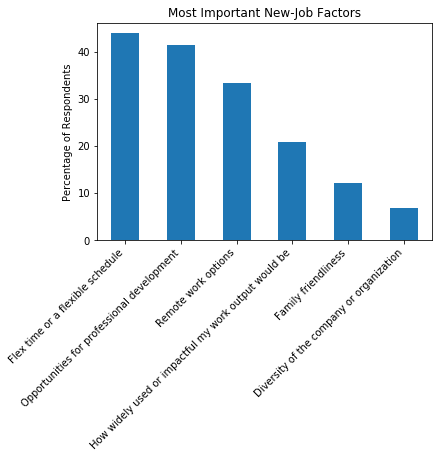

In [60]:
possible_vals_JobFactors = ["Remote work options", "Office environment of company culture",
                 "Financial performance or funding status of company or organization",
                 "Opportunities for professional development", "Diversity of the company or organization",
                 "How widely used or impactful my work output would be",
                 "Industry that I'd be working in", "Specific department or team I'd be working on",
                 "Flex time or a flexible schedule", "Languages, frameworks, and other technologies I'd be working with",
                 "Family friendliness"]

df_clean_JobFactors = df.dropna(subset=['JobFactors'],axis=0)
# factors_df,ax = clean_and_plot(df, possible_vals_JobFactors, 'JobFactors', 'Most Important Factors For New Job')
factors_df,ax = clean_and_plot(df_clean_JobFactors, possible_vals_JobFactors, 'JobFactors', 'Most Important New-Job Factors')
ax.set_xticklabels(list(factors_df.index),rotation=45, ha='right');
ax.set_xlabel('')
ax.set_ylabel('Percentage of Respondents')
factors_df

See how many respondents are even open to new job opportunities.

['I’m not actively looking, but I am open to new opportunities', 'I am not interested in new job opportunities', 'I am actively looking for a job']


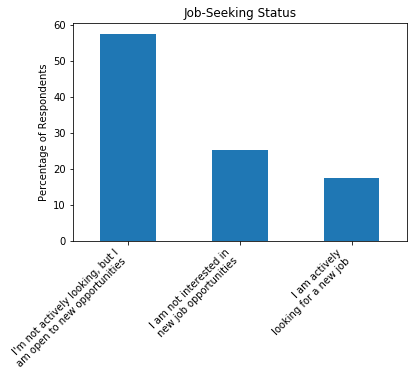

In [55]:
count_vals = df.JobSeek.value_counts() #Provide a pandas series of the counts for each job seek status
print(list(count_vals.index))

# ax = (count_vals[:10]/df.shape[0]).plot(kind="bar");
ax = (count_vals[:10]/df.dropna(subset=['JobSeek'],axis=0).shape[0]*100).plot(kind="bar");
plt.title("Job-Seeking Status");
# ax.set_xticklabels(list(count_vals.index),rotation=45, ha='right');
xlabs = ['I\'m not actively looking, but I\nam open to new opportunities','I am not interested in\nnew job opportunities','I am actively\nlooking for a new job']
ax.set_xticklabels(xlabs,rotation=45, ha='right');
ax.set_xlabel('');
ax.set_ylabel('Percentage of Respondents');

It looks like only about 25% of respondents are not interested in taking on a new job, with most people at least open to a change. This information can be used as motivation for companies to use the information presented here to interest developers in taking a job with them.

#### Question 3: How does the above analysis change for minority developers?

Now I'd like to look at the results above for minority respondents. Is there something a company might be able to do to attract more diverse applicants in particular?

First look at the breakdown to determine who should be included in the minority group according to race.

White or of European descent                                                                                     0.638069
South Asian                                                                                                      0.097219
Hispanic or Latino/a/x                                                                                           0.049099
Black or of African descent                                                                                      0.036781
Southeast Asian                                                                                                  0.036694
East Asian                                                                                                       0.036585
Middle Eastern                                                                                                   0.035301
Hispanic or Latino/a/x;White or of European descent                                                              0.016606
Middle Eastern;White or 

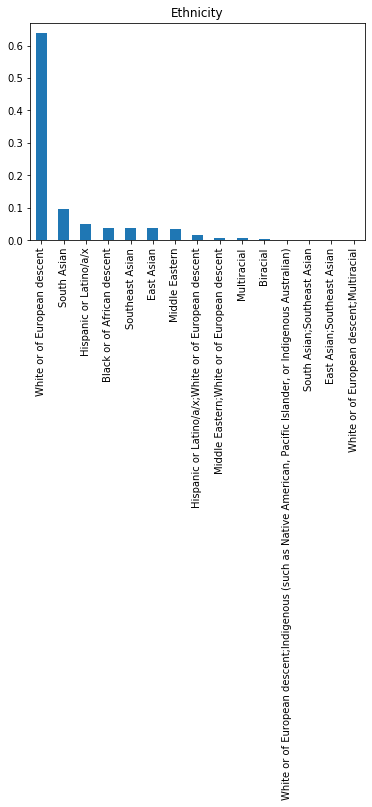

In [11]:
count_vals = df.Ethnicity.value_counts() #Provide a pandas series of the counts for each ethnicity

(count_vals[:15]/df.dropna(subset=['Ethnicity'],axis=0).shape[0]).plot(kind="bar");
plt.title("Ethnicity");

count_vals[:15]/df.dropna(subset=['Ethnicity'],axis=0).shape[0]

Based on the above results, I will take any race other than white (of European descent), add all women, and that will be the minority group I will consider. So, the non-minority group will be made up exclusively of white men.

Start by dividing the dataset.

In [12]:
df_whitemen = df[(df.Gender == 'Man') & (df.Ethnicity == 'White or of European descent')]

In [13]:
# df_minorities = df[~((df.Gender == 'Man') & (df.Ethnicity == 'White or of European descent'))]
df_minorities = df[~((df.Gender == 'Man') & (df.Ethnicity == 'White or of European descent')) & ~((df.Gender.isna()) & (df.Ethnicity.isna()))]
df_minorities.shape
# df_minorities[df_minorities.Gender.isna() & df_minorities.Ethnicity.isna()].shape # Check that eliminated all respondents who can't be classified as minority or non-minority

(24466, 61)

In [14]:
def make_chart(num_x_vals,df1,df2,title,leg=['White Men','Minorities']): # adapted from https://chrisalbon.com/python/data_visualization/matplotlib_grouped_bar_plot/
    # For now, make sure df1 and df2 indices are in the same order
    # Later, we can make df2 have same order as df1, which should be in some order that makes sense (decreasing for example)
    '''
    INPUT:
    num_x_vals - number of x-axis values you want to plot
    df1 - dataframe of first group
    df2 - dataframe of second group
    title - title for output plot
    (Optionally) leg - list of legend annotations

    OUTPUT:
    Displays a double bar plot of the 2 datasets
    '''
    
    
    df1_vals = []
    for i in range(df1.values.shape[0]):
        df1_vals.append(df1.values[i][0])
    df2_vals = []
    for i in range(df2.values.shape[0]):
        df2_vals.append(df2.values[i][0])
    
    # Setting the positions and width for the bars
    pos = list(range(num_x_vals)) 
    width = 0.25
#     width = 0.5

    # Plotting the bars
    fig, ax = plt.subplots(figsize=(10,5))

    # Create a bar with pre_score data,
    # in position pos,
    plt.bar([p + width for p in pos], 
            #using df['pre_score'] data,
            df1_vals,
            # of width
            width,
            # with alpha 0.5
            alpha=0.5, 
            # with color
            color='#EE3224', 
            # with label the first value in first_name
            label=df1.index[0])

    # Create a bar with mid_score data,
    # in position pos + some width buffer,
    plt.bar([p + width*2 for p in pos], 
            #using df['mid_score'] data,
            df2_vals,
            # of width
            width, 
            # with alpha 0.5
            alpha=0.5, 
            # with color
            color='#F78F1E', 
            # with label the second value in first_name
            label=df1.index[1])

    # Set the y axis label
    ax.set_ylabel('Proportion')

    # Set the chart's title
    ax.set_title(title)

    # Set the position of the x ticks
    ax.set_xticks([p + 1.5 * width for p in pos])

    # Set the labels for the x ticks
    ax.set_xticklabels(list(df1.index),rotation=90)
#     ax.xaxis.set_label_coords(-0.3, 0.5) #added as test

    # Setting the x-axis and y-axis limits
    plt.xlim(min(pos)-width, max(pos)+width*4)
#     plt.ylim([0, max(df1 + df2)])

    # Adding the legend and showing the plot
    plt.legend(leg, loc='upper right')
#     plt.grid()
    plt.show()

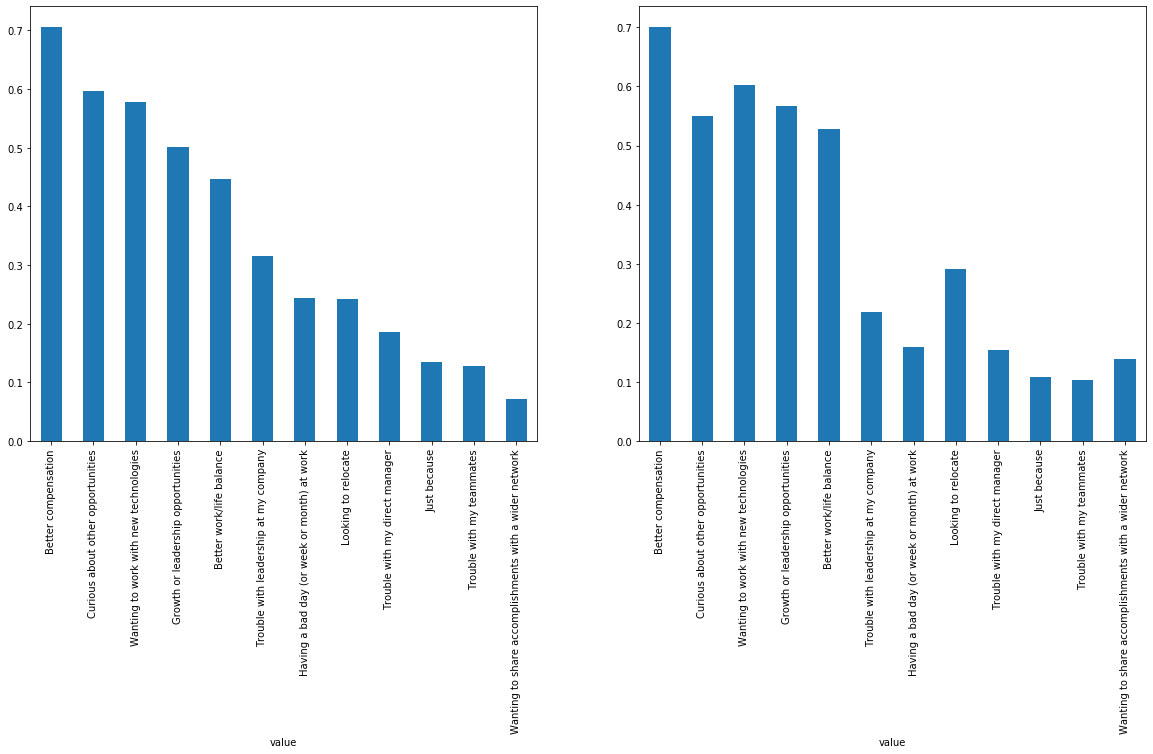

In [15]:
df_clean_whitemen_NEWJobHunt = df_whitemen.dropna(subset=['NEWJobHunt'],axis=0)
# drivers_df_whitemen = clean_and_plot(df_whitemen, possible_vals_NEWJobHunt,plot=False)
drivers_df_whitemen = clean_and_plot(df_clean_whitemen_NEWJobHunt, possible_vals_NEWJobHunt,plot=False)
df_clean_minorities_NEWJobHunt = df_minorities.dropna(subset=['NEWJobHunt'],axis=0)
# drivers_df_minorities = clean_and_plot(df_minorities, possible_vals_NEWJobHunt,plot=False)
drivers_df_minorities = clean_and_plot(df_clean_minorities_NEWJobHunt, possible_vals_NEWJobHunt,plot=False)

# drivers_df_whitemen.plot(kind='bar', legend=None);
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8))

drivers_df_whitemen.plot(ax=ax[0],kind='bar', legend=None);
# drivers_df_minorities.plot(ax=ax[1],kind='bar', legend=None);
drivers_order = list(drivers_df_whitemen.index)
drivers_df_minorities.loc[drivers_order].plot(ax=ax[1], kind="bar", legend=False);

Make a chart that's easier to compare the 2 groups.

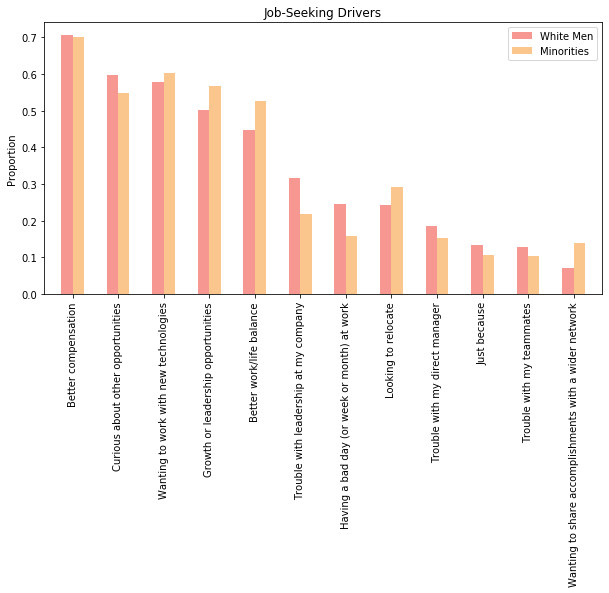

In [61]:
make_chart(drivers_df_whitemen.shape[0],drivers_df_whitemen,drivers_df_minorities.loc[drivers_order],'Job-Seeking Drivers')

Now look at the same thing, but isolating just women in one group, and comparing them to all men.

In [17]:
df_men = df[df.Gender == 'Man']
df_women = df[df.Gender == 'Woman']

df_clean_men_NEWJobHunt = df_men.dropna(subset=['NEWJobHunt'],axis=0)
# drivers_df_men = clean_and_plot(df_men, possible_vals_NEWJobHunt,plot=False)
drivers_df_men = clean_and_plot(df_clean_men_NEWJobHunt, possible_vals_NEWJobHunt,plot=False)
df_clean_women_NEWJobHunt = df_women.dropna(subset=['NEWJobHunt'],axis=0)
# drivers_df_women = clean_and_plot(df_women, possible_vals_NEWJobHunt,plot=False)
drivers_df_women = clean_and_plot(df_clean_women_NEWJobHunt, possible_vals_NEWJobHunt,plot=False)

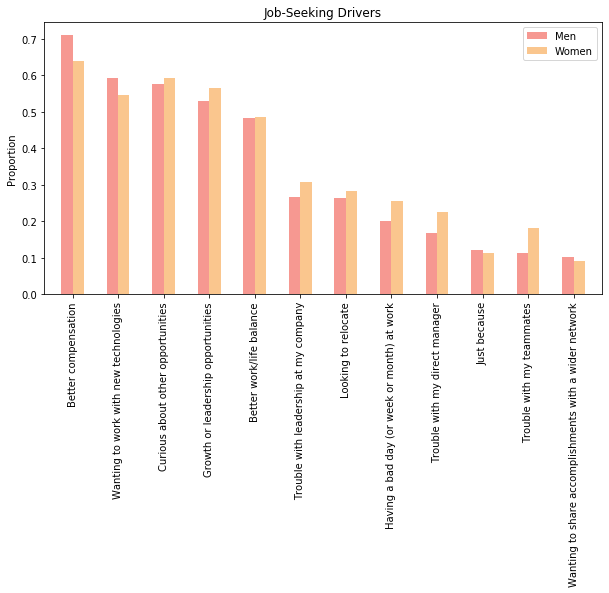

In [62]:
drivers_men_order = list(drivers_df_men.index)
make_chart(drivers_df_men.shape[0],drivers_df_men,drivers_df_women.loc[drivers_men_order],'Job-Seeking Drivers',leg=['Men','Women'])

The clearest plot to show differences may be one that just has a bar indicating difference between the groups, ordered by largest difference. Make a function for plotting that below, then use for white men vs. minorities and men vs. women.

In [66]:
def plot_difference_chart(df1,df2):
    '''
    INPUT:
    df1 - dataframe of first group
    df2 - dataframe of second group

    OUTPUT:
    Displays a bar plot of differences between values in df1 and df2 (df1-df2)
    ax - axis handle to plot
    df_drivers_dem - dataframe of df1 combined with df2 with addition of a difference column
    '''
    
    df1_vals = []
    for i in range(df1.values.shape[0]):
        df1_vals.append(df1.values[i][0])
    df2_vals = []
    for i in range(df2.values.shape[0]):
        df2_vals.append(df2.values[i][0])

    index = list(df1.index)

    d = {'factor': index, 'group1': df1_vals, 'group2': df2_vals}
    df_drivers_dem = pd.DataFrame(data=d)
    df_drivers_dem.set_index('factor', inplace=True)

#     df_drivers_dem['difference'] = df_drivers_dem.columns[1]-df_drivers_dem.columns[0]
    df_drivers_dem['difference'] = df_drivers_dem.group2-df_drivers_dem.group1
    
    df_drivers_dem

    # plot difference
    ax = (df_drivers_dem.difference.sort_values(ascending=False)*100).plot(kind='bar');
    ax.grid(axis='y');
    ax.set_xticklabels(df_drivers_dem.difference.sort_values(ascending=False).index,rotation=45, ha='right');
    
    return ax,df_drivers_dem

,group1,group2,difference
factor,,,
Better compensation,0.705807,0.700502,-0.005305
Curious about other opportunities,0.597451,0.549870,-0.047581
Wanting to work with new technologies,0.577436,0.602360,0.024924
Growth or leadership opportunities,0.501978,0.566301,0.064322
Better work/life balance,0.447594,0.528037,0.080443
Trouble with leadership at my company,0.315681,0.219110,-0.096570
Having a bad day (or week or month) at work,0.244686,0.158957,-0.085729
Looking to relocate,0.243121,0.291669,0.048548
Trouble with my direct manager,0.186896,0.153443,-0.033453


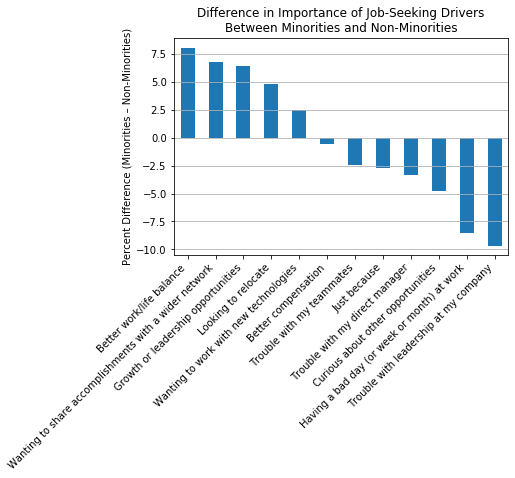

In [67]:
ax,df_drivers_minority = plot_difference_chart(drivers_df_whitemen,drivers_df_minorities.loc[drivers_order])
ax.set(xlabel="", ylabel="Percent Difference (Minorities – Non-Minorities)", title="Difference in Importance of Job-Seeking Drivers\nBetween Minorities and Non-Minorities");
df_drivers_minority

,group1,group2,difference
factor,,,
Better compensation,0.710037,0.638699,-0.071338
Wanting to work with new technologies,0.593482,0.546918,-0.046564
Curious about other opportunities,0.575638,0.592123,0.016486
Growth or leadership opportunities,0.529409,0.566096,0.036687
Better work/life balance,0.483982,0.484932,0.000950
Trouble with leadership at my company,0.267720,0.308219,0.040499
Looking to relocate,0.262878,0.284247,0.021368
Having a bad day (or week or month) at work,0.200935,0.256164,0.055229
Trouble with my direct manager,0.166823,0.224658,0.057834


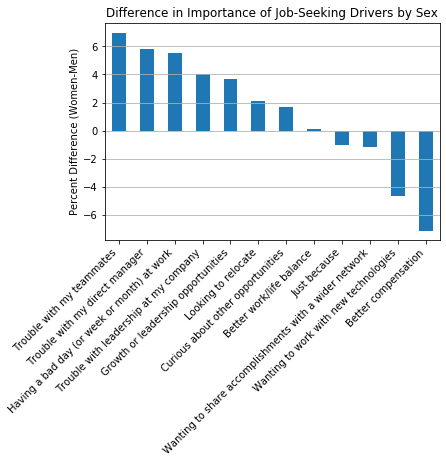

In [70]:
ax,df_drivers_sex = plot_difference_chart(drivers_df_men,drivers_df_women.loc[drivers_men_order])
ax.set(xlabel="", ylabel="Percent Difference (Women-Men)", title="Difference in Importance of Job-Seeking Drivers by Sex");
df_drivers_sex

Now do the same for the question about most important factors for a new job.

,count
value,
Flex time or a flexible schedule,0.461529
Opportunities for professional development,0.384055
Remote work options,0.352975
How widely used or impactful my work output would be,0.214651
Family friendliness,0.124729
Diversity of the company or organization,0.042504


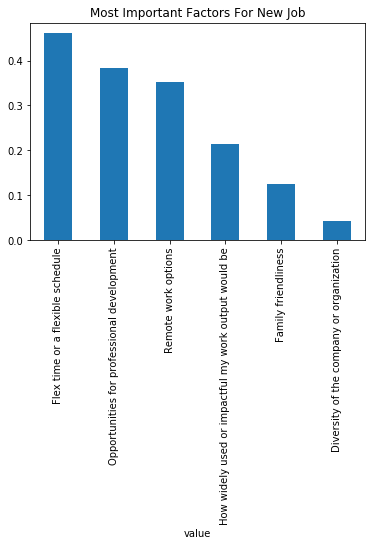

In [22]:
df_clean_whitemen_JobFactors = df_whitemen.dropna(subset=['JobFactors'],axis=0)
# factors_df_whitemen,ax = clean_and_plot(df_whitemen, possible_vals_JobFactors, 'JobFactors', 'Most Important Factors For New Job')
factors_df_whitemen,ax = clean_and_plot(df_clean_whitemen_JobFactors, possible_vals_JobFactors, 'JobFactors', 'Most Important Factors For New Job')
factors_df_whitemen

,count
value,
Opportunities for professional development,0.445445
Flex time or a flexible schedule,0.418702
Remote work options,0.313458
How widely used or impactful my work output would be,0.203393
Family friendliness,0.115204
Diversity of the company or organization,0.096375


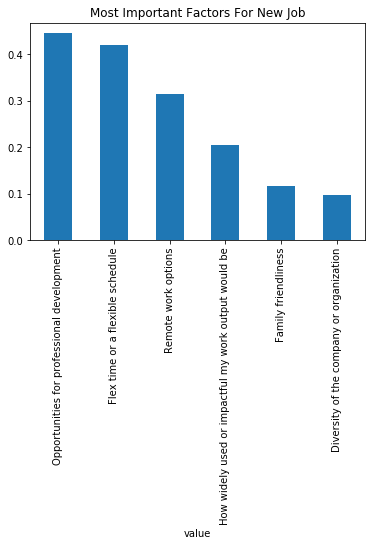

In [23]:
df_clean_minorities_JobFactors = df_minorities.dropna(subset=['JobFactors'],axis=0)
# factors_df_minorities,ax = clean_and_plot(df_minorities, possible_vals_JobFactors, 'JobFactors', 'Most Important Factors For New Job')
factors_df_minorities,ax = clean_and_plot(df_clean_minorities_JobFactors, possible_vals_JobFactors, 'JobFactors', 'Most Important Factors For New Job')
factors_df_minorities

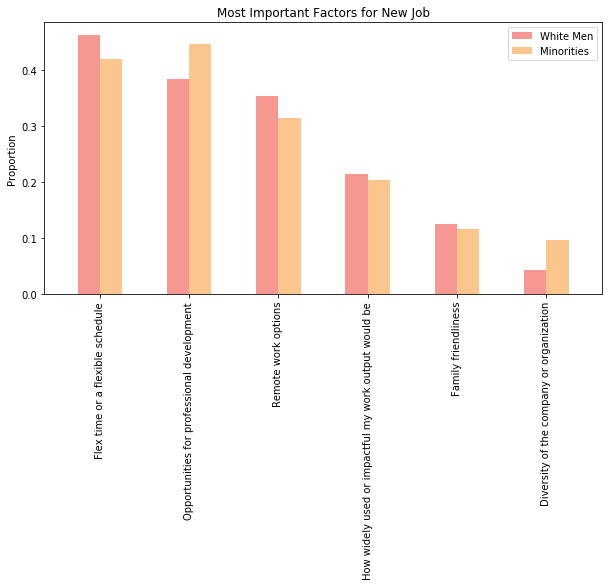

In [24]:
factors_order = list(factors_df_whitemen.index)
make_chart(factors_df_whitemen.shape[0],factors_df_whitemen,factors_df_minorities.loc[factors_order],'Most Important Factors for New Job')

,group1,group2,difference
factor,,,
Flex time or a flexible schedule,0.461529,0.418702,-0.042827
Opportunities for professional development,0.384055,0.445445,0.061390
Remote work options,0.352975,0.313458,-0.039517
How widely used or impactful my work output would be,0.214651,0.203393,-0.011258
Family friendliness,0.124729,0.115204,-0.009524
Diversity of the company or organization,0.042504,0.096375,0.053871


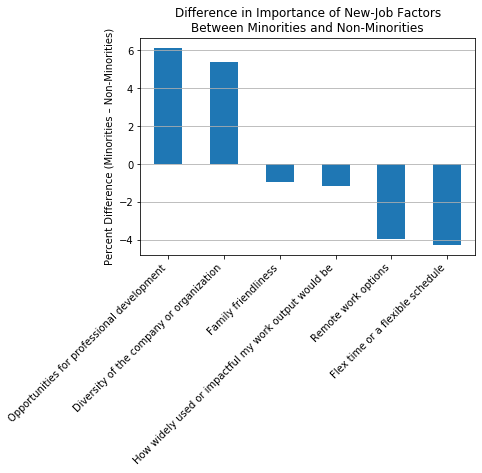

In [68]:
ax,df_factors_minority = plot_difference_chart(factors_df_whitemen,factors_df_minorities.loc[factors_order])
ax.set(xlabel="", ylabel="Percent Difference (Minorities – Non-Minorities)", title="Difference in Importance of New-Job Factors\nBetween Minorities and Non-Minorities");
df_factors_minority

In [26]:
df_clean_men_JobFactors = df_men.dropna(subset=['JobFactors'],axis=0)
# factors_df_men = clean_and_plot(df_men, possible_vals_JobFactors,'JobFactors','Most Important Factors For New Job',plot=False)
factors_df_men = clean_and_plot(df_clean_men_JobFactors, possible_vals_JobFactors,'JobFactors','Most Important Factors For New Job',plot=False)

df_clean_women_JobFactors = df_women.dropna(subset=['JobFactors'],axis=0)
# factors_df_women = clean_and_plot(df_women, possible_vals_JobFactors,'JobFactors', 'Most Important Factors For New Job',plot=False)
factors_df_women = clean_and_plot(df_clean_women_JobFactors, possible_vals_JobFactors,'JobFactors', 'Most Important Factors For New Job',plot=False)

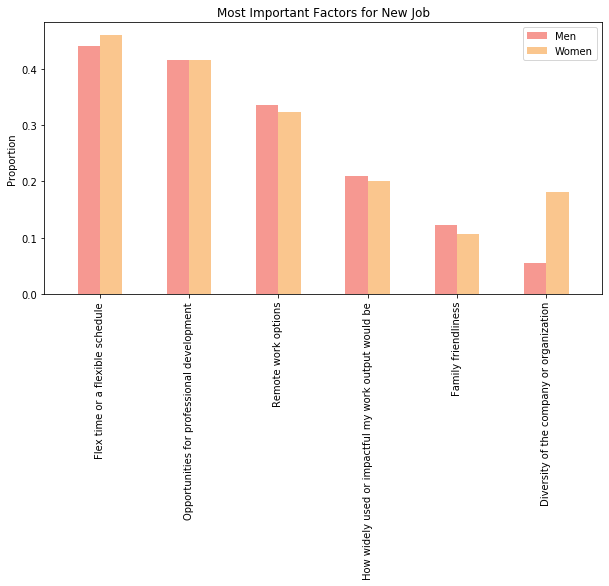

In [27]:
factors_men_order = list(factors_df_men.index)
make_chart(factors_df_men.shape[0],factors_df_men,factors_df_women.loc[factors_men_order],'Most Important Factors for New Job',leg=['Men','Women'])

,group1,group2,difference
factor,,,
Flex time or a flexible schedule,0.440644,0.459513,0.018869
Opportunities for professional development,0.415062,0.414779,-0.000283
Remote work options,0.335833,0.322480,-0.013353
How widely used or impactful my work output would be,0.209884,0.200453,-0.009431
Family friendliness,0.121841,0.107305,-0.014536
Diversity of the company or organization,0.054436,0.180917,0.126482


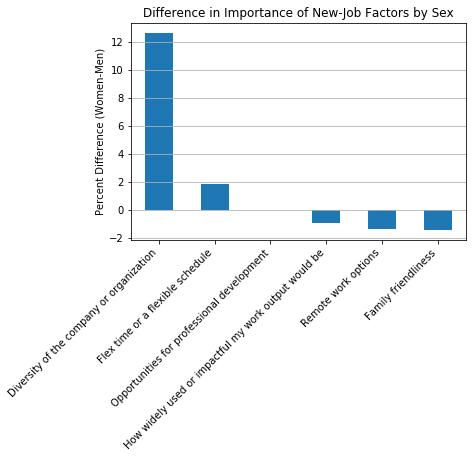

In [69]:
ax,df_factors_sex = plot_difference_chart(factors_df_men,factors_df_women.loc[factors_men_order])
ax.set(xlabel="", ylabel="Percent Difference (Women-Men)", title="Difference in Importance of New-Job Factors by Sex");
df_factors_sex

I'd like to add some statistical tests these differences (women vs. men and minorities vs. non-minorities)

First, check assumptions and follow statistical test from https://stattrek.com/hypothesis-test/difference-in-proportions.aspx:

Assumptions:
1. The sampling method for each population is simple random sampling.
2. The samples are independent.
3. Each sample includes at least 10 successes and 10 failures.
4. Each population is at least 20 times as big as its sample.

Comments on assumptions:
1. We will assume that the survey responses are a random sample of the developer population. This is not unreasonable, since it was taken voluntarily by the Stack Overflow community, which is a very popular community for developers, and none of my analysis deals with questions related to Stack Overflow in particular.
2. The dataset women (df_women) and dataset men (df_men) are independent, as are the minority (df_minorities) and non-minority (df_whitemen) datasets.
3. We will test this assumption for each test as I proceed below.
4. According to https://www.c-sharpcorner.com/article/how-many-software-developers-are-there-in-the-world/#:~:text=Do%20you%20ever%20wonder%20how,to%2027.7%20million%20by%202023, there were 23 million developers in 2018. Our samples consisting of the full datasets are at least 20 times smaller than this (assuming the proportions of women, men, minorities, and non-minorities are consistent for the population). Eliminating the nulls, we have 41866 men for JobFactors and 36146 for NEWJobHunt, 3532 women for JobFactors and 2920 for NEWJobHunt, 24421 white men for JobFactors and 21734 for NEWJobFactors, and 21987 minorities for JobFactors and 18137 for NEWJobHunt.

In [29]:
print(df_clean_men_JobFactors.shape)
print(df_clean_men_NEWJobHunt.shape)

print(df_clean_women_JobFactors.shape)
print(df_clean_women_NEWJobHunt.shape)

print(df_clean_minorities_JobFactors.shape)
print(df_clean_minorities_NEWJobHunt.shape)

print(df_clean_whitemen_JobFactors.shape)
print(df_clean_whitemen_NEWJobHunt.shape)

n_men_JobFactors = df_clean_men_JobFactors.shape[0]
n_men_NEWJobHunt = df_clean_men_NEWJobHunt.shape[0]
n_women_JobFactors = df_clean_women_JobFactors.shape[0]
n_women_NEWJobHunt = df_clean_women_NEWJobHunt.shape[0]
n_minorities_JobFactors = df_clean_minorities_JobFactors.shape[0]
n_minorities_NEWJobHunt = df_clean_minorities_NEWJobHunt.shape[0]
n_whitemen_JobFactors = df_clean_whitemen_JobFactors.shape[0]
n_whitemen_NEWJobHunt = df_clean_whitemen_NEWJobHunt.shape[0]

(41866, 61)
(36146, 61)
(3532, 61)
(2920, 61)
(21987, 61)
(18137, 61)
(24421, 61)
(21734, 61)


In [30]:
import scipy

def get_p_value(p1,p2,n1,n2): # based on equations from https://stattrek.com/hypothesis-test/difference-in-proportions.aspx
    """Function for computing p-value for 2-proportion Z-test
    H_0 = p1-p2<=0
    H_1 = p1-p2>0
    
    INPUT:
        p1 = proportion of successes for sample group 1
        p2 - proportion of successes for sample group 2
        n1 = sample size of group 1
        n2 = sample size of group 2
    
    OUTPUT:
        Z-score
        p-value
    
    """
    p = (p1 * n1 + p2 * n2) / (n1 + n2) # pooled sample proportion
    SE = np.sqrt(p * (1 - p) * ((1/n1) + (1/n2))) # standard error
    z = (p1 - p2) / SE # test statistic, Z-score
    
    p_value = scipy.stats.norm.sf(abs(z)) #one-sided
    
    return z,p_value

def print_significance(df,factors_list,n_group_1,n_group_2,confidence=0.05):
    # Test for assumption #3
    for factor in factors_list:
        prop_2 = df.loc[factor,'group2']
        prop_1 = df.loc[factor,'group1']
        assert((prop_2*n_group_2>=10) & ((1-prop_2)*n_group_2>=10))
        assert((prop_1*n_group_1>=10) & ((1-prop_1)*n_group_1>=10))

        # Calculate Z-score and p-value
        z, p = get_p_value(prop_2,prop_1,n_group_2,n_group_1)
        
        print('FACTOR OR DRIVER: ', factor)
        print('p-value: ', p)
        if p<confidence:
            print('This difference is statistically significant with ', str((1-confidence)*100), '%')

In [35]:
print('New job FACTORS - difference between WOMEN and MEN:')
print_significance(df_factors_sex,list(df_factors_sex.index),n_men_JobFactors,n_women_JobFactors)
print('\nNew job FACTORS - difference between MINORITIES and NON_MINORITIES:')
print_significance(df_factors_minority,list(df_factors_minority.index),n_whitemen_JobFactors,n_minorities_JobFactors)
print('\nNew job DRIVERS - difference between WOMEN and MEN:')
print_significance(df_drivers_sex,list(df_drivers_sex.index),n_men_NEWJobHunt,n_women_NEWJobHunt)
print('\nNew job DRIVERS - difference between MINORITIES and NON_MINORITIES:')
print_significance(df_drivers_minority,list(df_drivers_minority.index),n_whitemen_NEWJobHunt,n_minorities_NEWJobHunt)

New job FACTORS - difference between WOMEN and MEN:
FACTOR OR DRIVER:  Flex time or a flexible schedule
p-value:  0.015065265546494866
This difference is statistically significant with  95.0 %
FACTOR OR DRIVER:  Opportunities for professional development
p-value:  0.4869169471530661
FACTOR OR DRIVER:  Remote work options
p-value:  0.0531681449550354
FACTOR OR DRIVER:  How widely used or impactful my work output would be
p-value:  0.09284651036212299
FACTOR OR DRIVER:  Family friendliness
p-value:  0.005440458948044954
This difference is statistically significant with  95.0 %
FACTOR OR DRIVER:  Diversity of the company or organization
p-value:  1.0025320226009297e-190
This difference is statistically significant with  95.0 %

New job FACTORS - difference between MINORITIES and NON_MINORITIES:
FACTOR OR DRIVER:  Flex time or a flexible schedule
p-value:  8.665429902777928e-21
This difference is statistically significant with  95.0 %
FACTOR OR DRIVER:  Opportunities for professional devel

#### Conclusion and Comments

Most of the differences found above are significant. A full discussion can be found in the Medium article linked to in the README.md.